In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import lightning as L
import matplotlib.pyplot as plt
from transphorm.model_components import SyntheticTSDataModule
from pathlib import Path
import seaborn as sns

In [3]:
# MAIN_PATH = Path(
    # "/Users/mds8301/Desktop/temp"
# )  # quest
# data_path = MAIN_PATH / "dopamine_full_timeseries_array.pt"
data_module = SyntheticTSDataModule(batch_size=64)
data_module.prepare_data()
data_module.setup('train')


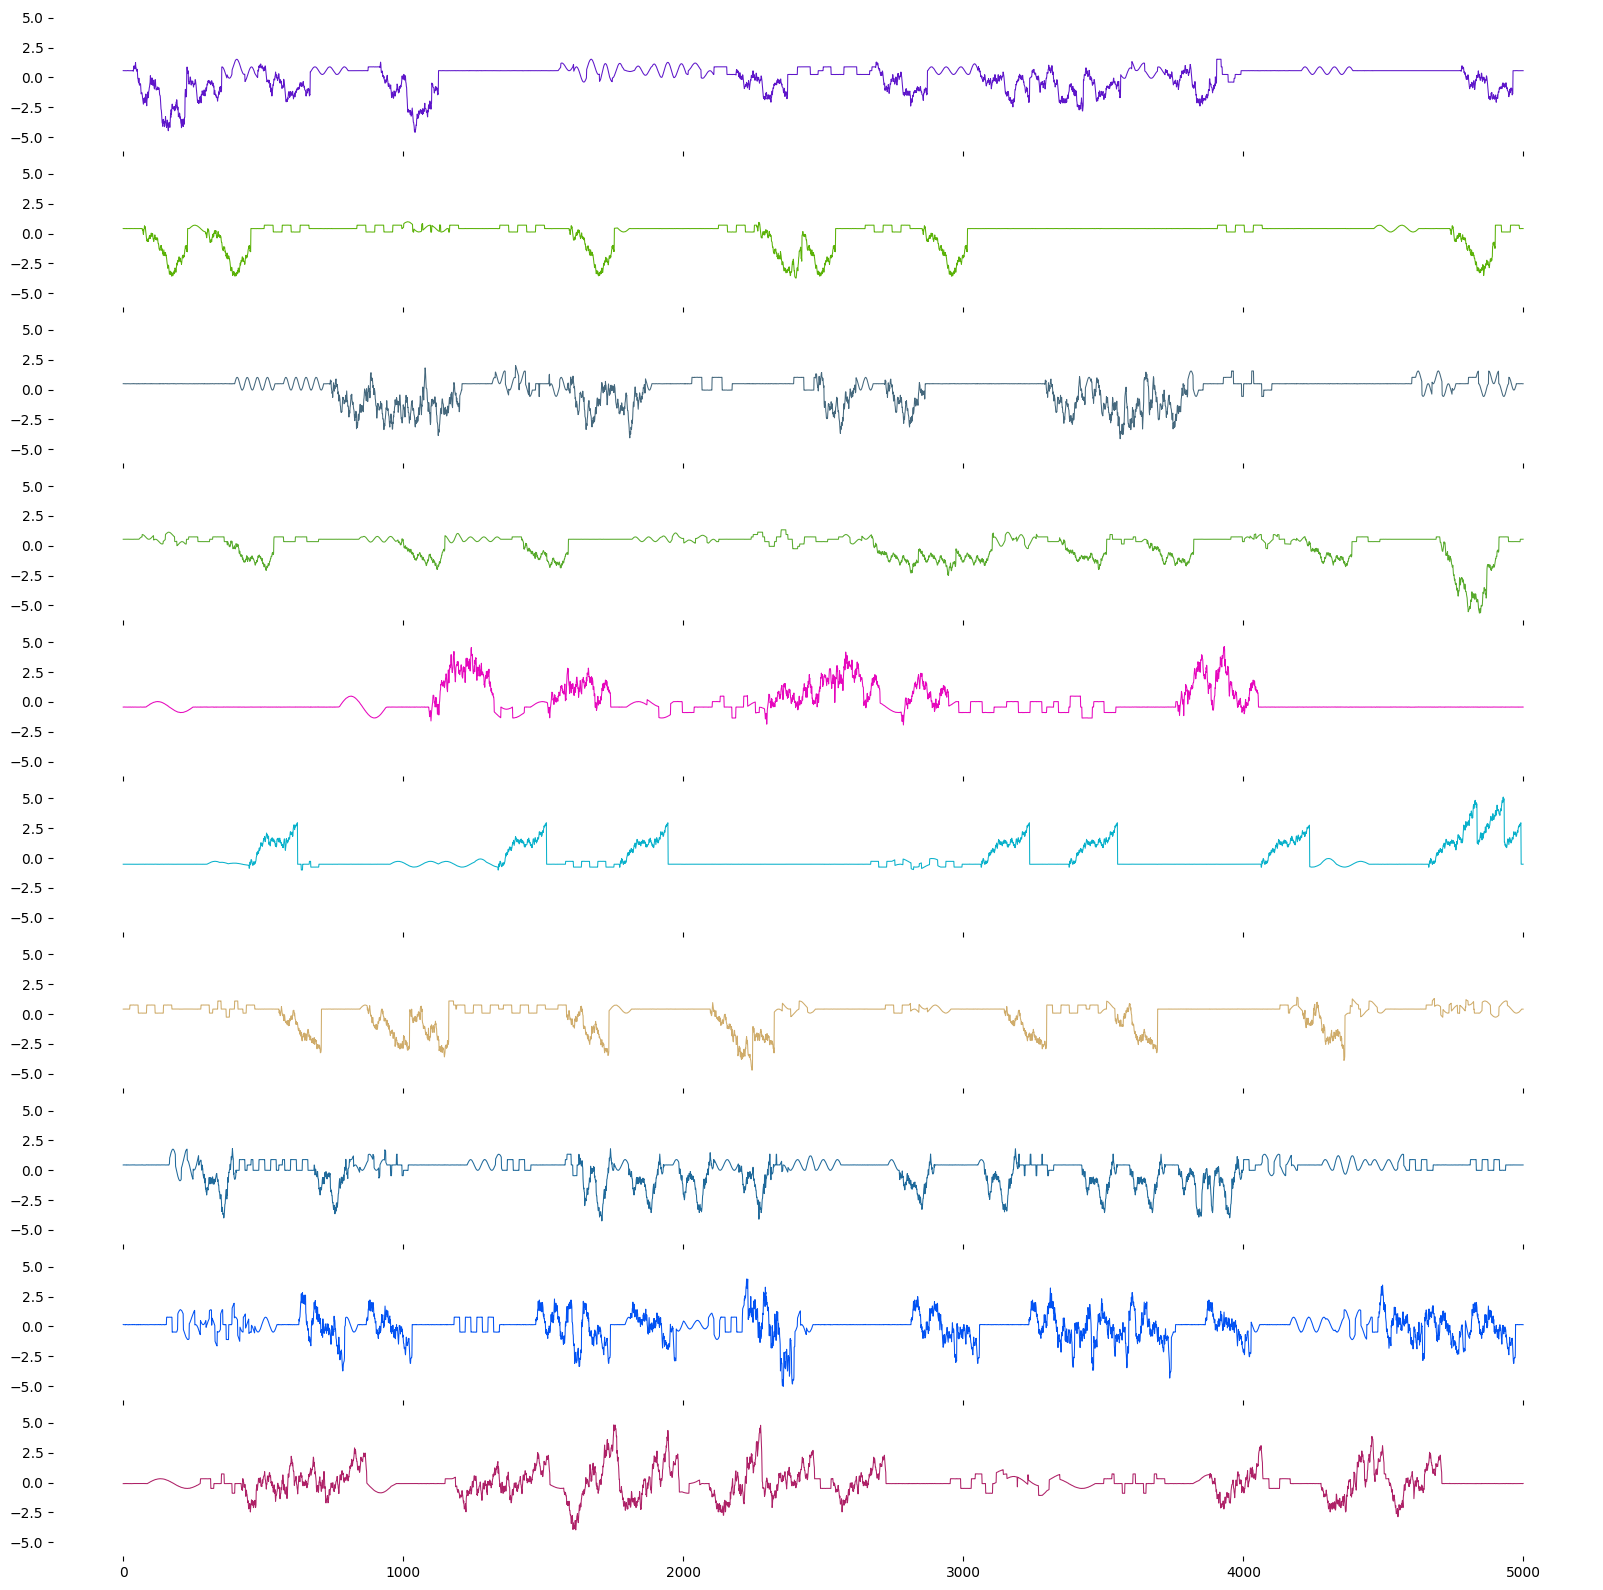

In [4]:
data_module._plot_first_10()

In [5]:
from transphorm.model_components.model_modules import AutoEncoder, VanilliaAutoEncoder
seq_length = data_module.tensor_shape[-1]
autoencoder = AutoEncoder(seq_length=seq_length, smallest_layer=256)
optimizer = torch.optim.Adam
van_ae = VanilliaAutoEncoder(model = autoencoder, optimizer=optimizer)

In [6]:
trainer = L.Trainer(max_epochs=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mds8301/anaconda3/envs/transphorm12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [7]:
trainer.fit(van_ae, data_module)


  | Name    | Type        | Params
----------------------------------------
0 | model   | AutoEncoder | 5.4 M 
1 | loss_fn | MSELoss     | 0     
----------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.554    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/Users/mds8301/anaconda3/envs/transphorm12/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


(tensor([[-0.8381, -0.8278, -0.8321,  ..., -0.8401, -0.8244, -0.8328],
         [ 0.2116,  0.2100,  0.2258,  ...,  0.2210,  0.2162,  0.2267],
         [ 0.4930,  0.4708,  0.7148,  ...,  0.4897,  0.4835,  0.4858],
         ...,
         [-0.2963, -0.2925, -0.2898,  ..., -0.2791, -0.2811, -0.2882],
         [-0.5909, -0.5868, -0.5836,  ..., -0.5889, -0.5992, -0.5922],
         [-0.5102, -0.5074, -0.5137,  ..., -0.5126, -0.5104, -0.5107]]),)